In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import nltk
from nltk.corpus import stopwords
from keras.preprocessing.sequence import pad_sequences
import re
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, InputLayer, Activation, Flatten, Embedding, LSTM,GRU, Bidirectional, SimpleRNN
from keras.initializers import Constant
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import seaborn as sns
import gensim
import gensim.downloader
from nltk.corpus import brown
import string

In [2]:
import nltk
nltk.download('brown')
nltk.download('punkt')

[nltk_data] Downloading package brown to /home/piyush/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /home/piyush/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
sents = brown.sents()
cleaned_sents = []
for i in sents:
    sentence = []
    for j in i :
        if j not in string.punctuation :
            sentence.append(j.lower())
    cleaned_sents.append(sentence)

In [4]:
model = gensim.models.Word2Vec(cleaned_sents,size=50,window=7,min_count=1)

In [5]:
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")  

In [6]:
def class_counts(ratings):    
    # find # of elements of each class
    cnts = ratings.value_counts()
    class1_count = cnts[1]
    class2_count = cnts[2]
    class3_count = cnts[3]
    class4_count = cnts[4]
    class5_count = cnts[5]
    
    return class1_count, class2_count, class3_count, class4_count, class5_count

def minority_class_count(ratings):
    return min(class_counts(ratings))


In [7]:
class1_data = train[train['ratings']==1]
class2_data = train[train['ratings']==2]
class3_data = train[train['ratings']==3]
class4_data = train[train['ratings']==4]
class5_data = train[train['ratings']==5]

minority_class_cnt = minority_class_count(train['ratings'])
class1_data = class1_data.sample(minority_class_cnt, random_state=1)
class2_data = class2_data.sample(minority_class_cnt, random_state=1)
class3_data = class3_data.sample(minority_class_cnt, random_state=1)
class4_data = class4_data.sample(minority_class_cnt, random_state=1)
class5_data = class5_data.sample(minority_class_cnt, random_state=1)

train = pd.concat([class1_data, class2_data, class3_data, class4_data, class5_data], axis=0)

In [8]:
def convert_to_lower(text):
    # return the reviews after convering then to lowercase
    lower_text = text.copy()
    for i in range(len(text)):
        lower_text[i] = text[i].lower()
    return lower_text

In [9]:
def remove_punctuation(text):
    #stop_words = set(stopwords.words('english'))
    without_punctuation_text  = text.copy()
    for i in range(len(text)):
        without_punctuation_text[i] = [w for w in text[i] if w.isalpha()]
    return without_punctuation_text

In [10]:
def perform_tokenization(text):
    tokenize_text = text.copy()
    for i in range(len(text)):
        tokenize_text[i] = nltk.word_tokenize(text[i])
    return tokenize_text

In [11]:
def get_dicts(train):
    reviews = train["reviews"].to_list()
    reviews = convert_to_lower(reviews)
    reviews = perform_tokenization(reviews)
    reviews = remove_punctuation(reviews)
    return reviews

In [12]:
review = get_dicts(train)

In [13]:
max_length=50
Embedding_dimension=50

In [14]:
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(review) 
sequences = tokenizer_obj.texts_to_sequences(review)
word_index = tokenizer_obj.word_index
review_pad = pad_sequences(sequences, maxlen=max_length) 

In [15]:
num_words = len(word_index)+1
embedding_matrix = np.zeros ((num_words, Embedding_dimension))
for word, i in word_index.items():
  try:
    embedding_vector = model.wv[word]
    embedding_matrix[i] = embedding_vector
  except:
    continue 

In [16]:
train_rating_list = train['ratings'].to_list()
Y = [str(i-1) for i in train_rating_list]
y_train = tf.keras.utils.to_categorical(Y,num_classes=5)

In [17]:
def preprocess_test(test_reviews):
  reviews = test_reviews
  reviews = convert_to_lower(reviews)
  reviews = perform_tokenization(reviews)
  reviews = remove_punctuation(reviews)
  return reviews

In [18]:
test_review = preprocess_test(test['reviews'])
test_review = test_review.to_list()
sequences_test = tokenizer_obj.texts_to_sequences(test_review)
test_review_pad = pad_sequences(sequences_test, maxlen=max_length) 

In [19]:
y_test = test['ratings']

In [20]:
def predict(model, test_reviews):
        y_pred = model.predict(test_reviews)
        pred1 = []
        for i in range(len(y_pred)):
            pred1.append(np.argmax(y_pred[i])+1)
        return pred1

In [21]:
def report(y_pred,y_test,Model,modelName):
    print("For model = ",modelName)
    Classification_report = classification_report(y_test,y_pred,target_names=['1','2','3','4','5'])
    cm  = confusion_matrix(test['ratings'],y_pred)
    print("Classification Report : \n",Classification_report)
    print("Heat Map :\n")
    sns.heatmap(cm,cmap="Blues",annot=True,fmt='.4g',xticklabels=['1','2','3','4','5'],yticklabels=['1','2','3','4','5'])

In [22]:
def lstmModel():
    model = Sequential()
    embedding_layer = Embedding(num_words,Embedding_dimension,embeddings_initializer=Constant(embedding_matrix), input_length = max_length, trainable=False)
    model.add(embedding_layer)
    model.add(LSTM(units=64, dropout=0.2,recurrent_dropout=0.2))
    model.add (Dense (64, activation='sigmoid'))
    model.add (Dense (5, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [23]:
lstm  = lstmModel()
lstm.fit(review_pad, y_train, batch_size=64, epochs=15, validation_split=0.25)


Epoch 1/15
133/133 [==============================] - 8s 61ms/step - loss: 1.3798 - accuracy: 0.2987 - val_loss: 5.2323 - val_accuracy: 7.0621e-04
Epoch 2/15
133/133 [==============================] - 9s 70ms/step - loss: 1.3068 - accuracy: 0.3594 - val_loss: 5.6188 - val_accuracy: 0.0844
Epoch 3/15
133/133 [==============================] - 9s 69ms/step - loss: 1.2681 - accuracy: 0.4043 - val_loss: 5.9445 - val_accuracy: 0.1338
Epoch 4/15
133/133 [==============================] - 7s 49ms/step - loss: 1.2451 - accuracy: 0.4163 - val_loss: 6.2876 - val_accuracy: 0.0823
Epoch 5/15
133/133 [==============================] - 7s 54ms/step - loss: 1.2227 - accuracy: 0.4293 - val_loss: 6.5218 - val_accuracy: 0.0621
Epoch 6/15
133/133 [==============================] - 6s 46ms/step - loss: 1.2099 - accuracy: 0.4319 - val_loss: 6.7324 - val_accuracy: 0.0915
Epoch 7/15
133/133 [==============================] - 8s 61ms/step - loss: 1.1924 - accuracy: 0.4497 - val_loss: 6.8900 - val_accuracy: 0.

In [24]:
y_pred = predict(lstm, test_review_pad)

For model =  LSTM Model
Classification Report : 
               precision    recall  f1-score   support

           1       0.31      0.58      0.41      1271
           2       0.11      0.38      0.17       630
           3       0.22      0.36      0.28       911
           4       0.15      0.43      0.22      1404
           5       0.00      0.00      0.00      5784

    accuracy                           0.19     10000
   macro avg       0.16      0.35      0.22     10000
weighted avg       0.09      0.19      0.12     10000

Heat Map :



/home/piyush/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


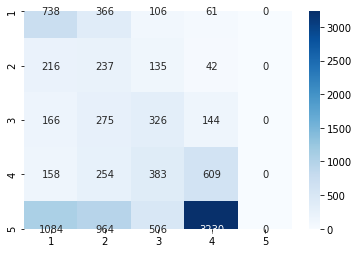

In [25]:
report(y_pred, y_test, lstm,"LSTM Model")

In [26]:
def bilstmModel():
    model = Sequential()
    embedding_layer = Embedding(num_words,Embedding_dimension,embeddings_initializer=Constant(embedding_matrix), input_length = max_length, trainable=False)
    model.add(embedding_layer)
    model.add(Bidirectional(LSTM(units=64, dropout=0.2,recurrent_dropout=0.2)))
    model.add (Dense (64, activation='sigmoid'))
    model.add (Dense (5, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [27]:
bilstm  = bilstmModel()
bilstm.fit(review_pad, y_train, batch_size=64, epochs=15, validation_split=0.25)

Epoch 1/15
133/133 [==============================] - 8s 62ms/step - loss: 1.4135 - accuracy: 0.2702 - val_loss: 4.9039 - val_accuracy: 0.0000e+00
Epoch 2/15
133/133 [==============================] - 7s 54ms/step - loss: 1.3448 - accuracy: 0.3285 - val_loss: 5.0354 - val_accuracy: 0.0611
Epoch 3/15
133/133 [==============================] - 7s 54ms/step - loss: 1.3005 - accuracy: 0.3672 - val_loss: 5.2355 - val_accuracy: 0.0646
Epoch 4/15
133/133 [==============================] - 8s 58ms/step - loss: 1.2681 - accuracy: 0.3917 - val_loss: 5.4996 - val_accuracy: 0.0667
Epoch 5/15
133/133 [==============================] - 7s 56ms/step - loss: 1.2459 - accuracy: 0.4083 - val_loss: 5.6711 - val_accuracy: 0.0632
Epoch 6/15
133/133 [==============================] - 8s 59ms/step - loss: 1.2214 - accuracy: 0.4278 - val_loss: 5.7396 - val_accuracy: 0.0590
Epoch 7/15
133/133 [==============================] - 8s 60ms/step - loss: 1.2145 - accuracy: 0.4266 - val_loss: 5.7891 - val_accuracy: 0.

For model =  Bi-LSTM Model
Classification Report : 
               precision    recall  f1-score   support

           1       0.29      0.68      0.41      1271
           2       0.12      0.28      0.16       630
           3       0.24      0.34      0.28       911
           4       0.14      0.43      0.22      1404
           5       0.00      0.00      0.00      5784

    accuracy                           0.20     10000
   macro avg       0.16      0.35      0.21     10000
weighted avg       0.09      0.20      0.12     10000

Heat Map :



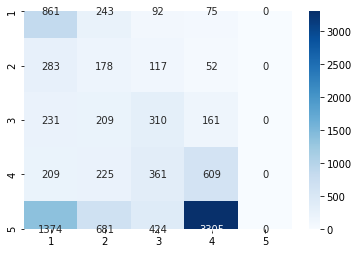

In [28]:
y_pred = predict(bilstm, test_review_pad)
report(y_pred, y_test, bilstm,"Bi-LSTM Model")

In [29]:
def gruModel():
    model = Sequential()
    embedding_layer = Embedding(num_words,Embedding_dimension,embeddings_initializer=Constant(embedding_matrix), input_length = max_length, trainable=False)
    model.add(embedding_layer)
    model.add(GRU(units= 64,dropout=0.2,recurrent_dropout=0.2))
    model.add (Dense (64, activation='sigmoid'))
    model.add (Dense (5, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [30]:
gru  = gruModel()
gru.fit(review_pad, y_train, batch_size=64, epochs=15, validation_split=0.25)

Epoch 1/15
133/133 [==============================] - 5s 40ms/step - loss: 1.3914 - accuracy: 0.2845 - val_loss: 5.1949 - val_accuracy: 0.0000e+00
Epoch 2/15
133/133 [==============================] - 6s 45ms/step - loss: 1.3302 - accuracy: 0.3431 - val_loss: 5.4774 - val_accuracy: 0.0636
Epoch 3/15
133/133 [==============================] - 6s 42ms/step - loss: 1.2808 - accuracy: 0.3756 - val_loss: 5.8834 - val_accuracy: 0.0632
Epoch 4/15
133/133 [==============================] - 5s 38ms/step - loss: 1.2497 - accuracy: 0.4133 - val_loss: 6.2494 - val_accuracy: 0.0985
Epoch 5/15
133/133 [==============================] - 4s 33ms/step - loss: 1.2303 - accuracy: 0.4238 - val_loss: 6.3280 - val_accuracy: 0.0703
Epoch 6/15
133/133 [==============================] - 4s 32ms/step - loss: 1.2088 - accuracy: 0.4357 - val_loss: 6.4865 - val_accuracy: 0.1172
Epoch 7/15
133/133 [==============================] - 4s 32ms/step - loss: 1.1934 - accuracy: 0.4501 - val_loss: 6.8119 - val_accuracy: 0.

For model =  GRU Model
Classification Report : 
               precision    recall  f1-score   support

           1       0.30      0.70      0.42      1271
           2       0.13      0.23      0.17       630
           3       0.24      0.36      0.29       911
           4       0.14      0.47      0.22      1404
           5       0.00      0.00      0.00      5784

    accuracy                           0.20     10000
   macro avg       0.16      0.35      0.22     10000
weighted avg       0.09      0.20      0.12     10000

Heat Map :



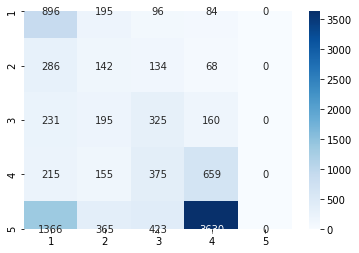

In [31]:
y_pred = predict(gru, test_review_pad)
report(y_pred, y_test, gru,"GRU Model")

In [32]:
def bigruModel():
    model = Sequential()
    embedding_layer = Embedding(num_words,Embedding_dimension,embeddings_initializer=Constant(embedding_matrix), input_length = max_length, trainable=False)
    model.add(embedding_layer)
    model.add(Bidirectional(GRU(units= 64,dropout=0.2,recurrent_dropout=0.2)))
    model.add (Dense (64, activation='sigmoid'))
    model.add (Dense (5, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [33]:
bigru  = bigruModel()
bigru.fit(review_pad, y_train, batch_size=64, epochs=15, validation_split=0.25)

Epoch 1/15
133/133 [==============================] - 8s 63ms/step - loss: 1.3970 - accuracy: 0.2812 - val_loss: 5.3226 - val_accuracy: 0.0018
Epoch 2/15
133/133 [==============================] - 7s 56ms/step - loss: 1.3218 - accuracy: 0.3495 - val_loss: 5.4878 - val_accuracy: 0.0858
Epoch 3/15
133/133 [==============================] - 7s 52ms/step - loss: 1.2671 - accuracy: 0.4034 - val_loss: 5.8223 - val_accuracy: 0.0346
Epoch 4/15
133/133 [==============================] - 7s 50ms/step - loss: 1.2403 - accuracy: 0.4185 - val_loss: 6.1275 - val_accuracy: 0.1006
Epoch 5/15
133/133 [==============================] - 7s 51ms/step - loss: 1.2257 - accuracy: 0.4248 - val_loss: 6.2603 - val_accuracy: 0.0953
Epoch 6/15
133/133 [==============================] - 7s 50ms/step - loss: 1.2034 - accuracy: 0.4438 - val_loss: 6.4242 - val_accuracy: 0.0904
Epoch 7/15
133/133 [==============================] - 8s 58ms/step - loss: 1.1986 - accuracy: 0.4505 - val_loss: 6.6427 - val_accuracy: 0.1020

For model =  Bidirectional GRU Model
Classification Report : 
               precision    recall  f1-score   support

           1       0.31      0.63      0.42      1271
           2       0.13      0.21      0.16       630
           3       0.21      0.44      0.29       911
           4       0.14      0.45      0.22      1404
           5       0.00      0.00      0.00      5784

    accuracy                           0.20     10000
   macro avg       0.16      0.35      0.22     10000
weighted avg       0.09      0.20      0.12     10000

Heat Map :



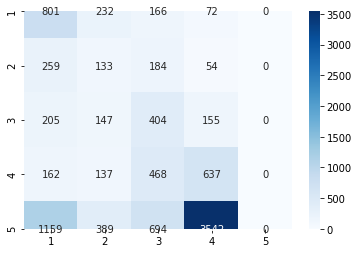

In [34]:
y_pred = predict(bigru, test_review_pad)
report(y_pred, y_test, bigru,"Bidirectional GRU Model")

In [35]:
def rnnModel():
    model = Sequential()
    embedding_layer = Embedding(num_words,Embedding_dimension,embeddings_initializer=Constant(embedding_matrix), input_length = max_length, trainable=False)
    model.add(embedding_layer)
    model.add(SimpleRNN(units= 64,dropout=0.2,recurrent_dropout=0.2))
    model.add (Dense (64, activation='sigmoid'))
    model.add (Dense (5, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [36]:
rnn  = rnnModel()
rnn.fit(review_pad, y_train, batch_size=64, epochs=15, validation_split=0.25)


Epoch 1/15
133/133 [==============================] - 2s 18ms/step - loss: 1.4198 - accuracy: 0.2773 - val_loss: 5.0370 - val_accuracy: 0.0000e+00
Epoch 2/15
133/133 [==============================] - 2s 16ms/step - loss: 1.3751 - accuracy: 0.2914 - val_loss: 5.6193 - val_accuracy: 7.0621e-04
Epoch 3/15
133/133 [==============================] - 2s 15ms/step - loss: 1.3692 - accuracy: 0.3010 - val_loss: 5.8452 - val_accuracy: 0.0823
Epoch 4/15
133/133 [==============================] - 2s 15ms/step - loss: 1.3553 - accuracy: 0.3161 - val_loss: 6.1919 - val_accuracy: 0.0487
Epoch 5/15
133/133 [==============================] - 3s 19ms/step - loss: 1.3561 - accuracy: 0.3166 - val_loss: 6.3931 - val_accuracy: 0.0512
Epoch 6/15
133/133 [==============================] - 3s 20ms/step - loss: 1.3417 - accuracy: 0.3372 - val_loss: 6.4329 - val_accuracy: 0.0272
Epoch 7/15
133/133 [==============================] - 2s 16ms/step - loss: 1.3446 - accuracy: 0.3337 - val_loss: 6.6625 - val_accuracy

For model =  RNN Model
Classification Report : 
               precision    recall  f1-score   support

           1       0.24      0.55      0.33      1271
           2       0.08      0.08      0.08       630
           3       0.12      0.49      0.19       911
           4       0.17      0.31      0.22      1404
           5       0.00      0.00      0.00      5784

    accuracy                           0.16     10000
   macro avg       0.12      0.29      0.16     10000
weighted avg       0.07      0.16      0.09     10000

Heat Map :



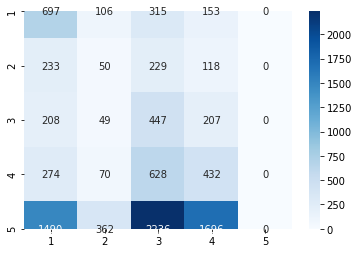

In [37]:
y_pred = predict(rnn, test_review_pad)
report(y_pred, y_test, rnn,"RNN Model")